In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import os
!pip -q install pandas-ta==0.3.14b0 --force-reinstall
# from numpy import NaN as npNaN
npNaN = np.nan
!sed -i 's/from numpy import NaN as npNaN/import numpy as np\nnpNaN = np.nan/' /usr/local/lib/python3.11/dist-packages/pandas_ta/momentum/squeeze_pro.py
import pandas_ta as ta
from datetime import datetime, date
!pip -q install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git
from tvDatafeed import TvDatafeed, Interval
! pip -q install yfinance --upgrade --no-cache-dir
import yfinance as yf

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Preparing metadata (setup.py) ... done


In [2]:
def get_data_yahoof(name):
  df = yf.Ticker(name).history(period="max", interval="1d")
  try:
    df.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1, inplace=True)
  except:
    print('cant drop')
  df.index = pd.to_datetime(df.index)
  return df

In [3]:
tv = TvDatafeed("adam799","cix87879@jioso.com")

def get_data_tradingView(name,n_bars=100000):
  df = tv.get_hist(symbol="EGX:"+str(name), exchange="EGX", interval=Interval.in_daily, n_bars=n_bars)
  if df is None:
    print(f"Error: Could not retrieve data for symbol EGX:{name}")
    return None

  try:
    df.drop(['symbol'], axis=1, inplace=True)
  except:
    print('Nothing to be droped')

  df.index = pd.to_datetime(df.index)
  df.rename(columns=lambda x: x.capitalize(), inplace=True)
  return df

In [4]:
try:
  os.mkdir('/content/EGX_Datasets')
except:
  pass

def preproccesing_data(name,n_bars=100000):
  df = get_data_tradingView(name,n_bars)
  # df = get_data_yahoof(name+'.CA')
  df['RSI'] = ta.rsi(df['Close'])
  df.ta.macd(append=True)
  df['SMA_20'] = df.ta.sma(length=20)
  df['SMA_50'] = df.ta.sma(length=50)
  try:
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['SMA_200'] = df['SMA_200'].bfill()
  except:pass
  df.ta.adx(append=True)
  df.ta.stoch(append=True)
  df.ta.cci(append=True)
  df.ta.bbands(append=True)
  df['OBV'] = ta.obv(close=df['Close'], volume=df['Volume'])
  # احسب Ichimoku
  ichimoku_df, _ = ta.ichimoku(df['High'], df['Low'], df['Close'])
  df = pd.concat([df, ichimoku_df], axis=1)
  df['ICS_26'] = df['Close'].shift(26)

  # حساب المتوسط المتحرك للحجم على 10 أيام
  df['Volume_MA'] = df['Volume'].rolling(window=10).mean()

  # حساب الـ Volume Trend اليومي
  df['Volume_Trend'] = (df['Volume'] - df['Volume_MA']) / df['Volume_MA'] * 100

  # التأكد من إن مفيش قيم Infinity أو NaN
  df['Volume_Trend'] = df['Volume_Trend'].replace([np.inf, -np.inf], 0)
  df['Volume_Trend'] = df['Volume_Trend'].fillna(0)

  # حذف العمود المساعد (Volume_MA) لو مش محتاجه
  df = df.drop(columns=['Volume_MA'])

  df['Price_Volume_Corr'] = df['Close'].rolling(window=14).corr(df['Volume']).fillna(0)

  df.rename(columns={
    'MACD_12_26_9': 'MACD',
    'MACDh_12_26_9': 'MACD_Hist',
    'MACDs_12_26_9': 'MACD_Signal',
    'ADX_14': 'ADX',
    'DMP_14': 'ADX_Plus_DI',
    'DMN_14': 'ADX_Minus_DI',
    'STOCHk_14_3_3': 'Stoch_K',
    'STOCHd_14_3_3': 'Stoch_D',
    'CCI_14_0.015': 'CCI',
    'BBL_5_2.0': 'BB_Lower',
    'BBM_5_2.0': 'BB_Middle',
    'BBU_5_2.0': 'BB_Upper',
    'BBP_5_2.0': 'BB_Percentage'
    }, inplace=True)

  df.dropna(inplace=True)

  save_path = ('/content/EGX_Datasets/'+name+'_data.csv')
  df.to_csv(save_path)
  return save_path

In [5]:
# def create_weekly_text_description(row, df):
#     score = 0
#     row_index = row.name
#     start_index = max(0, row_index - 6)
#     last_7_days = df.iloc[start_index:row_index + 1]

#     # Trend Direction
#     higher_high_count = last_7_days['Higher_High_7d'].sum()
#     higher_low_count = last_7_days['Higher_Low_7d'].sum()
#     if higher_high_count >= 5 and higher_low_count >= 5:
#         trend_direction = 'The stock shows Higher Highs and Higher Lows in 5+ of the last 7 days, indicating a **very strong uptrend**.'
#         score += 4  # إيجابي جدًا
#     elif higher_high_count == 4 and higher_low_count == 4:
#         trend_direction = 'The stock shows Higher Highs and Higher Lows in 4 of the last 7 days, indicating an **uptrend**.'
#         score += 2  # إيجابي
#     elif higher_high_count <= 2 and higher_low_count <= 2:
#         trend_direction = 'The stock shows Lower Highs and Lower Lows in 5+ of the last 7 days, indicating a **very strong downtrend**.'
#         score -= 4  # سلبي جدًا
#     elif higher_high_count == 3 and higher_low_count == 3:
#         trend_direction = 'The stock shows Lower Highs and Lower Lows in 4 of the last 7 days, indicating a **downtrend**.'
#         score -= 2  # سلبي
#     else:
#         trend_direction = 'The stock shows a mixed trend over the last 7 days with no clear Higher Highs or Higher Lows pattern, suggesting a **sideways movement**.'
#         # محايد: score لا يتغير

#     # Volume Analysis
#     volume_analysis = ''
#     if row['Relative_Volume_3d'] > 2:
#         volume_analysis = 'Trading volume is very high (%.2f times the average), suggesting very strong momentum and a **very positive** movement.' % row['Relative_Volume_3d']
#         score += 4  # إيجابي جدًا
#     elif 1.5 < row['Relative_Volume_3d'] <= 2:
#         volume_analysis = 'Trading volume is high (%.2f times the average), suggesting strong momentum and a **positive** movement.' % row['Relative_Volume_3d']
#         score += 2  # إيجابي
#     elif row['Relative_Volume_3d'] < 0.3:
#         volume_analysis = 'Trading volume is very low (%.2f times the average), indicating very weak momentum and a **very negative** movement.' % row['Relative_Volume_3d']
#         score -= 4  # سلبي جدًا
#     elif 0.3 <= row['Relative_Volume_3d'] < 0.5:
#         volume_analysis = 'Trading volume is low (%.2f times the average), indicating weak momentum and a **negative** movement.' % row['Relative_Volume_3d']
#         score -= 2  # سلبي
#     else:
#         volume_analysis = 'Trading volume is normal (%.2f times the average), suggesting a **neutral** movement.' % row['Relative_Volume_3d']
#         # محايد: score لا يتغير

#     # MACD Analysis
#     macd_analysis = ''
#     macd_trend = 'bullish' if row['MACD'] > row['MACD_Signal'] else 'bearish'
#     if macd_trend == 'bullish':
#         if row['MACD_Hist'] > 0.5:
#             macd_analysis = 'MACD indicates a **very strong bullish** trend with a histogram of %.2f.' % row['MACD_Hist']
#             score += 2  # إيجابي جدًا
#         else:
#             macd_analysis = 'MACD indicates a **bullish** trend with a histogram of %.2f.' % row['MACD_Hist']
#             score += 1  # إيجابي
#     else:
#         if row['MACD_Hist'] < -0.5:
#             macd_analysis = 'MACD indicates a **very strong bearish** trend with a histogram of %.2f.' % row['MACD_Hist']
#             score -= 2  # سلبي جدًا
#         else:
#             macd_analysis = 'MACD indicates a **bearish** trend with a histogram of %.2f.' % row['MACD_Hist']
#             score -= 1  # سلبي

#     # RSI Analysis
#     rsi_analysis = ''
#     if row['RSI'] > 80:
#         rsi_analysis = 'RSI at %.2f indicates **extremely overbought** conditions, suggesting a **strong reversal risk**.' % row['RSI']
#         score -= 2  # سلبي جدًا
#     elif 70 < row['RSI'] <= 80:
#         rsi_analysis = 'RSI at %.2f indicates **overbought** conditions, suggesting a potential reversal.' % row['RSI']
#         score -= 1  # سلبي
#     elif row['RSI'] < 20:
#         rsi_analysis = 'RSI at %.2f indicates **extremely oversold** conditions, suggesting a **strong reversal opportunity**.' % row['RSI']
#         score += 2  # إيجابي جدًا
#     elif 20 <= row['RSI'] < 30:
#         rsi_analysis = 'RSI at %.2f indicates **oversold** conditions, suggesting a potential reversal.' % row['RSI']
#         score += 1  # إيجابي
#     else:
#         rsi_analysis = 'RSI at %.2f indicates **neutral** conditions.' % row['RSI']
#         # محايد: score لا يتغير

#     # ADX Analysis
#     adx_analysis = ''
#     if row['ADX'] > 40:
#         adx_analysis = 'ADX at %.2f indicates a **very strong trend**, strongly supporting the current movement.' % row['ADX']
#         score += 2  # إيجابي جدًا
#     elif 25 < row['ADX'] <= 40:
#         adx_analysis = 'ADX at %.2f indicates a **strong trend**, supporting the current movement.' % row['ADX']
#         score += 1  # إيجابي
#     elif row['ADX'] < 10:
#         adx_analysis = 'ADX at %.2f indicates a **very weak trend**, suggesting a **strong sideways movement**.' % row['ADX']
#         score -= 2  # سلبي جدًا
#     elif 10 <= row['ADX'] < 15:
#         adx_analysis = 'ADX at %.2f indicates a **weak trend**, suggesting a **sideways movement**.' % row['ADX']
#         score -= 1  # سلبي
#     else:
#         adx_analysis = 'ADX at %.2f indicates a **neutral trend**.' % row['ADX']
#         # محايد: score لا يتغير

#     # SMA Analysis
#     sma_analysis = ''
#     price_to_sma_ratio = (row['Close'] - row['SMA']) / row['SMA'] * 100  # النسبة المئوية
#     if price_to_sma_ratio > 5:
#         sma_analysis = 'The price is significantly above the SMA (%.2f), indicating a **very positive** trend.' % row['SMA']
#         score += 2  # إيجابي جدًا
#     elif 0 < price_to_sma_ratio <= 5:
#         sma_analysis = 'The price is above the SMA (%.2f), indicating a **positive** trend.' % row['SMA']
#         score += 1  # إيجابي
#     elif price_to_sma_ratio < -5:
#         sma_analysis = 'The price is significantly below the SMA (%.2f), indicating a **very negative** trend.' % row['SMA']
#         score -= 2  # سلبي جدًا
#     elif -5 <= price_to_sma_ratio < 0:
#         sma_analysis = 'The price is below the SMA (%.2f), indicating a **negative** trend.' % row['SMA']
#         score -= 1  # سلبي
#     else:
#         sma_analysis = 'The price is at the SMA (%.2f), indicating a **neutral** trend.' % row['SMA']
#         # محايد: score لا يتغير

#     # Stochastic Analysis
#     stochastic_analysis = ''
#     if row['Stoch_K'] > 90:
#         stochastic_analysis = 'Stochastic K at %.2f indicates **extremely overbought** conditions, suggesting a **strong reversal risk**.' % row['Stoch_K']
#         score -= 2  # سلبي جدًا
#     elif 80 < row['Stoch_K'] <= 90:
#         stochastic_analysis = 'Stochastic K at %.2f indicates **overbought** conditions, suggesting a potential reversal.' % row['Stoch_K']
#         score -= 1  # سلبي
#     elif row['Stoch_K'] < 10:
#         stochastic_analysis = 'Stochastic K at %.2f indicates **extremely oversold** conditions, suggesting a **strong reversal opportunity**.' % row['Stoch_K']
#         score += 2  # إيجابي جدًا
#     elif 10 <= row['Stoch_K'] < 20:
#         stochastic_analysis = 'Stochastic K at %.2f indicates **oversold** conditions, suggesting a potential reversal.' % row['Stoch_K']
#         score += 1  # إيجابي
#     else:
#         stochastic_analysis = 'Stochastic K at %.2f indicates **neutral** momentum.' % row['Stoch_K']
#         # محايد: score لا يتغير

#     text = f"Over the past 7 days, the stock movement can be described as follows: {trend_direction} {volume_analysis} {macd_analysis} {rsi_analysis} {adx_analysis} {sma_analysis} {stochastic_analysis} (Score: {score})"
#     return text, score

#In Arabic
def create_weekly_text_description_ar(row, df):
    score = 0
    # row_index = row.name
    # start_index = max(0, row_index - 6)
    # last_7_days = df.iloc[start_index:row_index + 1]
    last_7_days = df.iloc[-7:]

    # تعريف متغيرات للكلمات الإنجليزية
    macd = 'الماك'
    rsi = 'ار اي اس'
    adx = 'ايه دي اكس'
    sma = 'اس ام ايه'
    stochastic = 'Stochastic'
    stochastic_k = 'الاوستاتستك'
    obv = 'اوه بي في'
    fibonacci = 'فابوناشي'
    ichimoku = 'اشيموكي'
    cci = 'سي سي اي'

    # تحليل الحجم
    volume_analysis = ''
    if row['Relative_Volume_3d'] > 2:
        volume_analysis = f'حجم التداول مرتفع جدا {row["Relative_Volume_3d"]:.2f} مرة من المتوسط مما يشير إلى نشاط سوقي قوي جدا.'
        score += 4
    elif 1.5 < row['Relative_Volume_3d'] <= 2:
        volume_analysis = f'حجم التداول مرتفع {row["Relative_Volume_3d"]:.2f} مرة من المتوسط مما يشير إلى نشاط سوقي قوي.'
        score += 2
    elif row['Relative_Volume_3d'] < 0.3:
        volume_analysis = f'حجم التداول منخفض جدا {row["Relative_Volume_3d"]:.2f} مرة من المتوسط مما يشير إلى اهتمام ضعيف جدا من المستثمرين.'
        score -= 4
    elif 0.3 <= row['Relative_Volume_3d'] < 0.5:
        volume_analysis = f'حجم التداول منخفض {row["Relative_Volume_3d"]:.2f} مرة من المتوسط مما يشير إلى اهتمام ضعيف من المستثمرين.'
        score -= 2
    else:
        volume_analysis = f'حجم التداول عادي {row["Relative_Volume_3d"]:.2f} مرة من المتوسط مما يشير إلى نشاط مستقر.'

    # تحليل MACD
    macd_analysis = ''
    macd_trend = 'صاعد' if row['MACD'] > row['MACD_Signal'] else 'هابط'
    macd_strength = row["MACD_Hist"]
    adx_score = row["ADX"]

    if row['ADX'] > 40:
        adx_trend_strength = 'قوي جدًا'
    elif 25 < row['ADX'] <= 40:
        adx_trend_strength = 'قوي'
    elif row['ADX'] < 10:
        adx_trend_strength = 'ضعيف جدًا'
    elif 10 <= row['ADX'] < 15:
        adx_trend_strength = 'ضعيف'
    else:
        adx_trend_strength = 'محايد'

    if macd_trend == 'صاعد':
        if macd_strength > 0.5:
            if adx_score >= 1:
                macd_analysis = f'مؤشر {macd} يشير إلى زخم إيجابي قوي جدًا (هيستوغرام = {macd_strength:.2f})، وهذا مدعوم باتجاه {adx_trend_strength}.'
                score += 2
            else:
                macd_analysis = f'مؤشر {macd} يشير إلى زخم إيجابي قوي (هيستوغرام = {macd_strength:.2f})، ولكن الاتجاه {adx_trend_strength} مما قد يشير إلى زخم **مضلل**.'
                score += 1
        else:
            if adx_score >= 1:
                macd_analysis = f'مؤشر {macd} يشير إلى زخم إيجابي معتدل (هيستوغرام = {macd_strength:.2f})، مدعوم باتجاه {adx_trend_strength}.'
                score += 1
            else:
                macd_analysis = f'مؤشر {macd} يشير إلى زخم إيجابي ضعيف (هيستوغرام = {macd_strength:.2f})، والاتجاه {adx_trend_strength} مما قد يشير إلى إشارات **غير مؤكدة**.'
                score += 0
    else:
        if macd_strength < -0.5:
            if adx_score >= 1:
                macd_analysis = f'مؤشر {macd} يشير إلى زخم سلبي قوي جدًا (هيستوغرام = {macd_strength:.2f})، وهذا مدعوم باتجاه {adx_trend_strength}.'
                score -= 2
            else:
                macd_analysis = f'مؤشر {macd} يشير إلى زخم سلبي قوي (هيستوغرام = {macd_strength:.2f})، ولكن الاتجاه {adx_trend_strength} مما قد يشير إلى زخم **مضلل**.'
                score -= 1
        else:
            if adx_score >= 1:
                macd_analysis = f'مؤشر {macd} يشير إلى زخم سلبي معتدل (هيستوغرام = {macd_strength:.2f})، مدعوم باتجاه {adx_trend_strength}.'
                score -= 1
            else:
                macd_analysis = f'مؤشر {macd} يشير إلى زخم سلبي ضعيف (هيستوغرام = {macd_strength:.2f})، والاتجاه {adx_trend_strength} مما قد يشير إلى إشارات **غير مؤكدة**.'
                score -= 0

    # تحليل RSI
    rsi_analysis = ''
    if 70 < row['RSI']:
        rsi_analysis = f'مؤشر {rsi} عند {row["RSI"]:.2f} يشير إلى حالة تشبع شرائي مما قد يعني تباطؤ أو انعكاس.'
        score -= 1
    elif row['RSI'] < 30:
        rsi_analysis = f'مؤشر {rsi} عند {row["RSI"]:.2f} يشير إلى حالة تشبع بيعي، مما يعزز فرصة الارتداد الصاعد.'
        score += 2
    else:
        rsi_analysis = f'مؤشر {rsi} عند {row["RSI"]:.2f} يعكس حالة عادية في السوق.'

    # تحليل Stochastic
    stochastic_analysis = ''
    if row['Stoch_K'] > 90:
        stochastic_analysis = f'مؤشر {stochastic_k} عند {row["Stoch_K"]:.2f} يشير إلى مستويات تشبع شرائي قوي جدا مما يوحي بمخاطر انعكاس قوية.'
        score -= 2
    elif 80 < row['Stoch_K'] <= 90:
        stochastic_analysis = f'مؤشر {stochastic_k} عند {row["Stoch_K"]:.2f} يشير إلى مستويات تشبع شرائي.'
        score -= 1
    elif row['Stoch_K'] < 10:
        stochastic_analysis = f'مؤشر {stochastic_k} عند {row["Stoch_K"]:.2f} يشير إلى مستويات تشبع بيعي قوي جدا مما يوحي بفرصة صعود قوية.'
        score += 2
    elif 10 <= row['Stoch_K'] < 20:
        stochastic_analysis = f'مؤشر {stochastic_k} عند {row["Stoch_K"]:.2f} يشير إلى مستويات تشبع بيعي.'
        score += 1
    else:
        stochastic_analysis = f'مؤشر {stochastic_k} عند {row["Stoch_K"]:.2f} يشير إلى زخم محايد.'

    # تحليل CCI
    cci_analysis_f = ''
    cci_analysis = ''
    price_action_analysis = ''

    def check_candlestick_pattern():
        if row['Close'] > row['Open']:
            return "شمعة صاعدة"
        elif row['Close'] < row['Open']:
            return "شمعة هابطة"
        else:
            return "شمعة محايدة"

    def check_support_resistance(df, lookback_period=50):
        recent_data = df.tail(lookback_period)  # الحصول على آخر 50 يومًا من البيانات
        support_level = recent_data['Low'].min()
        resistance_level = recent_data['High'].max()

        current_price = df.iloc[-1]['Close']  # السعر الحالي

        if current_price <= support_level * 1.05:  # إذا كان السعر قريبًا من مستوى الدعم (مثلاً +/- 5%)
            return "دعم قوي"
        elif current_price >= resistance_level * 0.95:  # إذا كان السعر قريبًا من مستوى المقاومة (مثلاً +/- 5%)
            return "مقاومة قوية"
        else:
            return "لا يوجد مستوى دعم أو مقاومة واضح"

    # تحليل CCI
    if row['CCI'] > 200:
        cci_analysis = f'مؤشر {cci} عند {row["CCI"]:.2f} يشير إلى حالة تشبع شرائي قوي جدا مما يعني مخاطر انعكاس قوية.'
    elif 100 < row['CCI'] <= 200:
        cci_analysis = f'مؤشر {cci} عند {row["CCI"]:.2f} يشير إلى حالة تشبع شرائي مما قد يعني تباطؤ أو انعكاس.'
    elif 0 < row['CCI'] <= 100:
        cci_analysis = f'مؤشر {cci} عند {row["CCI"]:.2f} يشير إلى زخم إيجابي بسيط.'
    elif row['CCI'] < -200:
        cci_analysis = f'مؤشر {cci} عند {row["CCI"]:.2f} يشير إلى حالة تشبع بيعي قوي جدا مما يوحي بفرصة صعود قوية.'
    elif -200 <= row['CCI'] < -100:
        cci_analysis = f'مؤشر {cci} عند {row["CCI"]:.2f} يشير إلى حالة تشبع بيعي مما يوحي بإمكانية تصحيح صعودي.'
    elif -100 <= row['CCI'] < 0:
        cci_analysis = f'مؤشر {cci} عند {row["CCI"]:.2f} يشير إلى زخم سلبي بسيط.'
    else:
        cci_analysis = f'مؤشر {cci} عند {row["CCI"]:.2f} يشير إلى زخم محايد.'

    # دمج التحليل مع نمط السعر
    price_action = check_candlestick_pattern()
    support_resistance = check_support_resistance(df)

    if price_action == "شمعة صاعدة" and row['CCI'] > 100:
        price_action_analysis = f'نمط السعر: {price_action} مع {cci} إيجابي يشير إلى احتمالية استمرار الزخم الصاعد.'
        score += 1
    elif price_action == "شمعة هابطة" and row['CCI'] < -100:
        price_action_analysis = f'نمط السعر: {price_action} مع {cci} سلبي يشير إلى احتمالية استمرار الزخم الهابط.'
        score -= 1
    elif support_resistance == "مقاومة قوية" and row['CCI'] > 200:
        price_action_analysis = f'السعر عند مقاومة قوية مع {cci} في منطقة تشبع شرائي يشير إلى احتمال انعكاس هبوطي.'
        score -= 3
    elif support_resistance == "دعم قوي" and row['CCI'] < -200:
        price_action_analysis = f'السعر عند دعم قوي مع {cci} في منطقة تشبع بيعي يشير إلى احتمال انعكاس صاعد.'
        score += 3
    else:
        price_action_analysis = f'نمط السعر لا يتعارض مع تحليل {cci}.'

    cci_analysis_f = cci_analysis + " " + price_action_analysis

    text = (
    f'خلال آخر 7 أيام، أظهر السهم {volume_analysis} '
    f'من جهة الزخم، {macd_analysis} '
    f'بينما {rsi_analysis}، و{stochastic_analysis}. '
    f'{cci_analysis_f}. '
    f'(التقييم الإجمالي: {score})'
)
    return text, score

In [6]:
# def create_monthly_text_description(row, df):
#     score = 0
#     row_index = row.name
#     start_index = max(0, row_index - 29)
#     last_30_days = df.iloc[start_index:row_index + 1]

#     # Trend Direction
#     higher_high_count = last_30_days['Higher_High_21d'].sum()
#     higher_low_count = last_30_days['Higher_Low_21d'].sum()
#     if higher_high_count >= 18 and higher_low_count >= 18:
#         trend_direction = 'The stock shows a **very strong positive** long-term trend with consistent Higher Highs and Higher Lows in 18+ days over the past month.'
#         score += 4  # إيجابي جدًا
#     elif higher_high_count >= 16 and higher_low_count >= 16:
#         trend_direction = 'The stock shows a **positive** long-term trend with consistent Higher Highs and Higher Lows in 16-17 days over the past month.'
#         score += 2  # إيجابي
#     elif higher_high_count <= 12 and higher_low_count <= 12:
#         trend_direction = 'The stock shows a **very strong negative** long-term trend with consistent Lower Highs and Lower Lows in 18+ days over the past month.'
#         score -= 4  # سلبي جدًا
#     elif higher_high_count <= 14 and higher_low_count <= 14:
#         trend_direction = 'The stock shows a **negative** long-term trend with consistent Lower Highs and Lower Lows in 16-17 days over the past month.'
#         score -= 2  # سلبي
#     else:
#         trend_direction = 'The stock exhibits a **neutral** long-term trend over the past month with mixed patterns.'
#         # محايد: score لا يتغير

#     # Volume Analysis
#     volume_analysis = ''
#     if row['Relative_Volume_21d'] > 2:
#         volume_analysis = 'The trading volume is **very high** (%.2f times the average), indicating very strong market activity.' % row['Relative_Volume_21d']
#         score += 4  # إيجابي جدًا
#     elif 1.5 < row['Relative_Volume_21d'] <= 2:
#         volume_analysis = 'The trading volume is **positively** higher than average (%.2f times), indicating strong market activity.' % row['Relative_Volume_21d']
#         score += 2  # إيجابي
#     elif row['Relative_Volume_21d'] < 0.3:
#         volume_analysis = 'The trading volume is **very low** (%.2f times the average), suggesting very weak investor interest.' % row['Relative_Volume_21d']
#         score -= 4  # سلبي جدًا
#     elif 0.3 <= row['Relative_Volume_21d'] < 0.5:
#         volume_analysis = 'The trading volume is **negatively** lower than average (%.2f times), suggesting weak investor interest.' % row['Relative_Volume_21d']
#         score -= 2  # سلبي
#     else:
#         volume_analysis = 'The trading volume remains **normal** (%.2f times), indicating stable activity.' % row['Relative_Volume_21d']
#         # محايد: score لا يتغير

#     # MACD Analysis
#     macd_analysis = ''
#     macd_trend = 'bullish' if row['MACD'] > row['MACD_Signal'] else 'bearish'
#     if macd_trend == 'bullish':
#         if row['MACD_Hist'] > 0.5:
#             macd_analysis = 'MACD suggests a **very strong positive** momentum with a histogram reading of %.2f.' % row['MACD_Hist']
#             score += 2  # إيجابي جدًا
#         else:
#             macd_analysis = 'MACD suggests a **positive** momentum with a histogram reading of %.2f.' % row['MACD_Hist']
#             score += 1  # إيجابي
#     else:
#         if row['MACD_Hist'] < -0.5:
#             macd_analysis = 'MACD suggests a **very strong negative** momentum with a histogram reading of %.2f.' % row['MACD_Hist']
#             score -= 2  # سلبي جدًا
#         else:
#             macd_analysis = 'MACD suggests a **negative** momentum with a histogram reading of %.2f.' % row['MACD_Hist']
#             score -= 1  # سلبي

#     # RSI Analysis
#     rsi_analysis = ''
#     if row['RSI'] > 80:
#         rsi_analysis = 'RSI at %.2f indicates an **extremely overbought** condition, signaling a strong risk of reversal.' % row['RSI']
#         score -= 2  # سلبي جدًا
#     elif 70 < row['RSI'] <= 80:
#         rsi_analysis = 'RSI at %.2f indicates an **overbought** condition, signaling a possible slowdown or reversal.' % row['RSI']
#         score -= 1  # سلبي
#     elif row['RSI'] < 20:
#         rsi_analysis = 'RSI at %.2f indicates an **extremely oversold** condition, suggesting a strong potential for upward correction.' % row['RSI']
#         score += 2  # إيجابي جدًا
#     elif 20 <= row['RSI'] < 30:
#         rsi_analysis = 'RSI at %.2f indicates an **oversold** condition, suggesting potential for upward correction.' % row['RSI']
#         score += 1  # إيجابي
#     else:
#         rsi_analysis = 'RSI at %.2f reflects a **normal** market condition.' % row['RSI']
#         # محايد: score لا يتغير

#     # ADX Analysis
#     adx_analysis = ''
#     if row['ADX'] > 40:
#         adx_analysis = 'ADX at %.2f highlights a **very strong** trend.' % row['ADX']
#         score += 2  # إيجابي جدًا
#     elif 25 < row['ADX'] <= 40:
#         adx_analysis = 'ADX at %.2f highlights a **strong** trend.' % row['ADX']
#         score += 1  # إيجابي
#     elif row['ADX'] < 10:
#         adx_analysis = 'ADX at %.2f suggests a **very weak** trend or **strong sideways movement**.' % row['ADX']
#         score -= 2  # سلبي جدًا
#     elif 10 <= row['ADX'] < 15:
#         adx_analysis = 'ADX at %.2f suggests a **weak** trend or **sideways movement**.' % row['ADX']
#         score -= 1  # سلبي
#     else:
#         adx_analysis = 'ADX at %.2f indicates a **neutral** trend.' % row['ADX']
#         # محايد: score لا يتغير

#     # SMA Analysis
#     sma_analysis = ''
#     price_to_sma_ratio = (row['Close'] - row['SMA']) / row['SMA'] * 100  # النسبة المئوية
#     if price_to_sma_ratio > 5:
#         sma_analysis = 'The price is **significantly above** the SMA (%.2f), supporting a **very positive** market view.' % row['SMA']
#         score += 2  # إيجابي جدًا
#     elif 0 < price_to_sma_ratio <= 5:
#         sma_analysis = 'The price is **above** the SMA (%.2f), supporting a **positive** market view.' % row['SMA']
#         score += 1  # إيجابي
#     elif price_to_sma_ratio < -5:
#         sma_analysis = 'The price is **significantly below** the SMA (%.2f), supporting a **very negative** market view.' % row['SMA']
#         score -= 2  # سلبي جدًا
#     elif -5 <= price_to_sma_ratio < 0:
#         sma_analysis = 'The price is **below** the SMA (%.2f), supporting a **negative** market view.' % row['SMA']
#         score -= 1  # سلبي
#     else:
#         sma_analysis = 'The price is **at** the SMA (%.2f), indicating a **neutral** trend.' % row['SMA']
#         # محايد: score لا يتغير

#     # Stochastic Analysis
#     stochastic_analysis = ''
#     if row['Stoch_K'] > 90:
#         stochastic_analysis = 'Stochastic K at %.2f signals **extremely overbought** levels, suggesting a strong risk of reversal.' % row['Stoch_K']
#         score -= 2  # سلبي جدًا
#     elif 80 < row['Stoch_K'] <= 90:
#         stochastic_analysis = 'Stochastic K at %.2f signals **overbought** levels.' % row['Stoch_K']
#         score -= 1  # سلبي
#     elif row['Stoch_K'] < 10:
#         stochastic_analysis = 'Stochastic K at %.2f signals **extremely oversold** levels, suggesting a strong potential for upward correction.' % row['Stoch_K']
#         score += 2  # إيجابي جدًا
#     elif 10 <= row['Stoch_K'] < 20:
#         stochastic_analysis = 'Stochastic K at %.2f signals **oversold** levels.' % row['Stoch_K']
#         score += 1  # إيجابي
#     else:
#         stochastic_analysis = 'Stochastic K at %.2f indicates **neutral** momentum.' % row['Stoch_K']
#         # محايد: score لا يتغير

#     text = f"Over the past 30 days, the stock performance can be summarized as follows: {trend_direction} {volume_analysis} {macd_analysis} {rsi_analysis} {adx_analysis} {sma_analysis} {stochastic_analysis} (Score: {score})"
#     return text, score

#In Arabic
def create_monthly_text_description_ar(row, df):
    score = 0
    row_index = row.name
    # start_index = max(0, row_index - 29)
    # last_30_days = df.iloc[start_index:row_index + 1]
    last_30_days = df.iloc[-30:]
    last_60_days = df.iloc[-60:]

    adx = 'ايه دي اكس'
    sma = 'اس ام ايه'
    sma20 = 'اس ام ايه 20'
    sma50 = 'اس ام ايه 50'
    sma200 = 'اس ام ايه 200'
    obv = 'اوه بي في'
    fibonacci = 'فابوناشي'
    ichimoku = 'الإيشيموكو'

    price_volume_corr = row['Price_Volume_Corr']
    higher_high_count = last_60_days['Higher_High_3d'].sum()
    higher_low_count = last_60_days['Higher_Low_3d'].sum()
    total_days = len(last_60_days) or 1

    hh_ratio = higher_high_count / total_days
    hl_ratio = higher_low_count / total_days

    # تحليل الاتجاه بناءً على Higher Highs / Higher Lows
    if hh_ratio >= 0.5 and hl_ratio >= 0.5:
        trend_direction = 'السهم يُظهر اتجاهًا صاعدًا قويًا على المدى القصير، حيث سجّل قممًا وقيعانًا أعلى في أكثر من نصف الأيام الأخيرة.'
        score += 4
    elif hh_ratio >= 0.4 and hl_ratio >= 0.4:
        trend_direction = 'السهم في اتجاه صاعد على المدى القصير، مع تسجيل قمم وقيعان أعلى في 40٪ إلى 50٪ من الأيام الأخيرة.'
        score += 2
    elif hh_ratio <= 0.25 and hl_ratio <= 0.25:
        trend_direction = 'السهم يُظهر اتجاهًا هابطًا قويًا على المدى القصير، حيث سجّل قممًا وقيعانًا أدنى في أقل من 25٪ من الأيام الأخيرة.'
        score -= 4
    elif hh_ratio <= 0.35 and hl_ratio <= 0.35:
        trend_direction = 'السهم في اتجاه هابط على المدى القصير، مع تسجيل قمم وقيعان أدنى في 25٪ إلى 35٪ من الأيام الأخيرة.'
        score -= 2
    elif hh_ratio > hl_ratio:
        trend_direction = 'السهم يتحرك عرضيًا مع ميل طفيف نحو الصعود، حيث تفوق عدد القمم الأعلى على القيعان الأعلى.'
        score += 1
    elif hl_ratio > hh_ratio:
        trend_direction = 'السهم يتحرك عرضيًا مع ميل طفيف نحو الهبوط، حيث تفوق عدد القيعان الأدنى على القمم الأعلى.'
        score -= 1
    else:
        trend_direction = 'السهم يتحرك في اتجاه عرضي خالص خلال الفترة الأخيرة، دون سيطرة واضحة للمشترين أو البائعين.'





    # تحليل ارتباط السعر بحجم التداول (Price-Volume Correlation)
    if price_volume_corr > 0.5:
        pv_analysis = 'الاتجاه قوي جداً مع حجم تداول مرتفع، مما يدعم الاتجاه الحالي بشكل كبير.'
        score += 4
    elif 0.2 < price_volume_corr <= 0.5:
        pv_analysis = 'الاتجاه قوي مع دعم من حجم تداول مرتفع إلى متوسط.'
        score += 2
    elif -0.5 <= price_volume_corr <= 0.2:
        pv_analysis = 'الاتجاه ضعيف أو محايد، وحجم التداول غير داعم له بشكل قوي.'
        score -= 2
    else:
        pv_analysis = 'الاتجاه ضعيف جداً مع حجم تداول منخفض، مما قد يعني ضعف في الاتجاه الحالي.'
        score -= 4

    # دمج تحليل الاتجاه مع تحليل حجم التداول
    trend_direction = f"{trend_direction} {pv_analysis}"


    # تحليل ADX
    adx_analysis = ''
    if row['ADX'] > 40:
        adx_analysis = f'مؤشر {adx} عند {row["ADX"]:.2f} يبرز اتجاها قويا جدا.'
        score += 2
    elif 25 < row['ADX'] <= 40:
        adx_analysis = f'مؤشر {adx} عند {row["ADX"]:.2f} يبرز اتجاها قويا.'
        score += 1
    elif row['ADX'] < 10:
        adx_analysis = f'مؤشر {adx} عند {row["ADX"]:.2f} يشير إلى اتجاه ضعيف جدا أو حركة جانبية قوية.'
        score -= 2
    elif 10 <= row['ADX'] < 15:
        adx_analysis = f'مؤشر {adx} عند {row["ADX"]:.2f} يشير إلى اتجاه ضعيف أو حركة جانبية.'
        score -= 1
    else:
        adx_analysis = f'مؤشر {adx} عند {row["ADX"]:.2f} يشير إلى اتجاه محايد.'

    # تحليل SMA
    # تحليل SMA لمختلف الفترات
    sma_analysis = ''
    sma_20 = row['SMA_20']
    sma_50 = row['SMA_50']
    sma_200 = row['SMA_200']

    # حساب نسبة السعر إلى المتوسط المتحرك SMA
    price_to_sma_20_ratio = (row['Close'] - sma_20) / sma_20 * 100
    price_to_sma_50_ratio = (row['Close'] - sma_50) / sma_50 * 100
    price_to_sma_200_ratio = (row['Close'] - sma_200) / sma_200 * 100

    # تحليل التقاطعات بين المتوسطات المتحركة
    if sma_20 > sma_50 and sma_50 > sma_200:
        sma_analysis = f'الاتجاه الصعودي قوي حيث أن {sma20} أعلى من {sma50} و{sma50} أعلى من {sma200}.'
    elif sma_20 < sma_50 and sma_50 < sma_200:
        sma_analysis = f'الاتجاه الهبوطي قوي حيث أن {sma20} أقل من {sma50} و{sma50} أقل من {sma200}.'
    elif sma_20 > sma_50 and sma_50 < sma_200:
        sma_analysis = f'السوق يشهد تقاطع صعودي قصير الأمد بين {sma20} و{sma50}، لكن {sma50} أقل من {sma200} مما يشير إلى ضعف في الاتجاه.'
    elif sma_20 < sma_50 and sma_50 > sma_200:
        sma_analysis = f'السوق يشهد تقاطع هبوطي قصير الأمد بين {sma20} و{sma50}، لكن {sma50} أعلى من {sma200} مما قد يشير إلى احتمال تحول في الاتجاه.'
    else:
        sma_analysis = f'لا يوجد اتجاه واضح بناءً على تقاطعات المتوسطات المتحركة في الوقت الحالي.'

    # إضافة التحليل مع معدل السعر إلى المتوسطات المختلفة
    if price_to_sma_20_ratio > 5:
        sma_analysis += f' السعر أعلى بكثير من {sma20} {sma_20:.2f} مما يدعم رؤية سوقية إيجابية جدًا.'
        score += 2
    elif 0 < price_to_sma_20_ratio <= 5:
        sma_analysis += f' السعر أعلى من {sma20} {sma_20:.2f} مما يدعم رؤية سوقية إيجابية.'
        score += 1
    elif price_to_sma_20_ratio < -5:
        sma_analysis += f' السعر أقل بكثير من {sma20} {sma_20:.2f} مما يدعم رؤية سوقية سلبية جدًا.'
        score -= 2
    elif -5 <= price_to_sma_20_ratio < 0:
        sma_analysis += f' السعر أقل من {sma20} {sma_20:.2f} مما يدعم رؤية سوقية سلبية.'
        score -= 1
    else:
        sma_analysis += f' السعر عند {sma200} {sma_20:.2f} مما يشير إلى اتجاه محايد.'

    # تحليل OBV
    obv_analysis = ''
    prev_obv = df['OBV'].iloc[row_index - 1] if row_index > 0 else row['OBV']
    prev_price = df['Close'].iloc[row_index - 1] if row_index > 0 else row['Close']
    obv_change = (row['OBV'] - prev_obv) / prev_obv if prev_obv != 0 else 0
    price_change = (row['Close'] - prev_price) / prev_price if prev_price != 0 else 0

    if obv_change > 0.05 and price_change > 0.05:
        obv_analysis = f'مؤشر {obv} يظهر زيادة قوية جدا  مع ارتفاع السعر مما يدعم الاتجاه الصاعد بقوة.'
        score += 3
    elif obv_change > 0.02 and price_change > 0.02:
        obv_analysis = f'مؤشر {obv} يظهر زيادة متوسطة  مع ارتفاع السعر مما يدعم الاتجاه الصاعد.'
        score += 2
    elif obv_change > 0 and price_change > 0:
        obv_analysis = f'مؤشر {obv} يظهر زيادة طفيفة  مع ارتفاع السعر مما يشير إلى دعم بسيط للاتجاه الصاعد.'
        score += 1
    elif obv_change < -0.05 and price_change < -0.05:
        obv_analysis = f'مؤشر {obv} يظهر انخفاضا قويا جدا  مع انخفاض السعر مما يدعم الاتجاه الهابط بقوة.'
        score -= 3
    elif obv_change < -0.02 and price_change < -0.02:
        obv_analysis = f'مؤشر {obv} يظهر انخفاضا متوسطا  مع انخفاض السعر مما يدعم الاتجاه الهابط.'
        score -= 2
    elif obv_change < 0 and price_change < 0:
        obv_analysis = f'مؤشر {obv} يظهر انخفاضا طفيفا  مع انخفاض السعر مما يشير إلى ضعف بسيط في الاتجاه الصاعد.'
        score -= 1
    else:
        obv_analysis = f'مؤشر {obv}  يظهر تناقض مع حركة السعر مما قد يشير إلى انعكاس محتمل.'
        score -= 1

    # تحليل Fibonacci Retracement
    fib_analysis = ''
    high_price = last_30_days['High'].max()
    low_price = last_30_days['Low'].min()
    price_range = high_price - low_price
    fib_levels = {
        '23.6%': high_price - (price_range * 0.236),
        '38.2%': high_price - (price_range * 0.382),
        '50%': high_price - (price_range * 0.5),
        '61.8%': high_price - (price_range * 0.618),
    }
    current_price = row['Close']
    nearest_level = min(fib_levels.items(), key=lambda x: abs(x[1] - current_price))
    fib_level, fib_value = nearest_level
    price_to_fib_ratio = (current_price - fib_value) / fib_value * 100

    if price_to_fib_ratio > 5:
        fib_analysis = f'السعر عند {current_price} أعلى بكثير من مستوى {fibonacci} {fib_level} عند {fib_value:.2f} مما يشير إلى قوة صعودية كبيرة.'
        score += 4
    elif 2 < price_to_fib_ratio <= 5:
        fib_analysis = f'السعر عند {current_price} أعلى من مستوى {fibonacci} {fib_level} عند {fib_value:.2f} مما يشير إلى قوة صعودية.'
        score += 2
    elif 0 < price_to_fib_ratio <= 2:
        fib_analysis = f'السعر عند {current_price} أعلى قليلا من مستوى {fibonacci} {fib_level} عند {fib_value:.2f} مما يشير إلى دعم صعودي بسيط.'
        score += 1
    elif price_to_fib_ratio < -5:
        fib_analysis = f'السعر عند {current_price} أقل بكثير من مستوى {fibonacci} {fib_level} عند {fib_value:.2f} مما يشير إلى ضعف كبير.'
        score -= 4
    elif -5 <= price_to_fib_ratio < -2:
        fib_analysis = f'السعر عند {current_price} أقل من مستوى {fibonacci} {fib_level} عند {fib_value:.2f} مما يشير إلى ضعف.'
        score -= 2
    else:
        fib_analysis = f'السعر عند {current_price} قريب من مستوى {fibonacci} {fib_level} عند {fib_value:.2f} مما قد يشير إلى دعم أو مقاومة محتملة.'
        score -= 1

    # تحليل Ichimoku Cloud
    ichimoku_analysis = ''
    ichimoku_score = 0  # هنحسب سكور داخلي لكل مكون ثم نحدد الحالة النهائية

    # 1. السعر بالنسبة للسحابة
    if row['Close'] > row['ISA_9'] and row['Close'] > row['ISB_26']:
        price_above_cloud = True
        cloud_distance = (row['Close'] - max(row['ISA_9'], row['ISB_26'])) / max(row['ISA_9'], row['ISB_26']) * 100
        if cloud_distance > 5:
            ichimoku_score += 2  # بعيد فوق السحابة
        else:
            ichimoku_score += 1  # فوق السحابة بس قريب
    elif row['Close'] < row['ISA_9'] and row['Close'] < row['ISB_26']:
        price_above_cloud = False
        cloud_distance = (min(row['ISA_9'], row['ISB_26']) - row['Close']) / min(row['ISA_9'], row['ISB_26']) * 100
        if cloud_distance > 5:
            ichimoku_score -= 2  # بعيد تحت السحابة
        else:
            ichimoku_score -= 1  # تحت السحابة بس قريب
    else:
        price_above_cloud = None  # داخل السحابة

    # 2. تقاطع Tenkan-sen وKijun-sen
    tenkan_kijun_cross = 'صاعد' if row['ITS_9'] > row['IKS_26'] else 'هابط'
    if tenkan_kijun_cross == 'صاعد':
        ichimoku_score += 1
    else:
        ichimoku_score -= 1

    # 3. Chikou Span
    past_price = df['Close'].iloc[row_index - 26] if row_index >= 26 else row['Close']
    chikou_span_position = 'صاعد' if row['ICS_26'] > past_price else 'هابط'
    if chikou_span_position == 'صاعد':
        ichimoku_score += 1
    else:
        ichimoku_score -= 1

    # 4. اتجاه السحابة
    cloud_direction = 'صاعد' if row['ISA_9'] > row['ISB_26'] else 'هابط'
    if cloud_direction == 'صاعد':
        ichimoku_score += 1
    else:
        ichimoku_score -= 1

    # 5. سمك السحابة
    cloud_thickness = abs(row['ISA_9'] - row['ISB_26']) / min(row['ISA_9'], row['ISB_26']) * 100
    if cloud_thickness > 5:
        if cloud_direction == 'صاعد':
            ichimoku_score += 1  # سحابة سميكة صاعدة
        else:
            ichimoku_score -= 1  # سحابة سميكة هابطة

    # تحديد الحالة النهائية بناءً على الـ ichimoku_score
    if ichimoku_score >= 4:
        ichimoku_analysis = (f'مؤشر {ichimoku} يظهر إشارة صعودية قوية جدا: السعر {"فوق" if price_above_cloud else "داخل"} السحابة، '
                            f'تقاطع {tenkan_kijun_cross} بين Tenkan-sen وKijun-sen، Chikou Span {chikou_span_position}، '
                            f'واتجاه السحابة {cloud_direction} مع سمك {cloud_thickness:.2f}%.')
        score += 4
    elif 2 <= ichimoku_score < 4:
        ichimoku_analysis = (f'مؤشر {ichimoku} يظهر إشارة صعودية: السعر {"فوق" if price_above_cloud else "داخل"} السحابة، '
                            f'تقاطع {tenkan_kijun_cross} بين Tenkan-sen وKijun-sen، Chikou Span {chikou_span_position}، '
                            f'واتجاه السحابة {cloud_direction} مع سمك {cloud_thickness:.2f}%.')
        score += 2
    elif 0 < ichimoku_score < 2:
        ichimoku_analysis = (f'مؤشر {ichimoku} يظهر إشارة صعودية بسيطة: السعر {"فوق" if price_above_cloud else "داخل"} السحابة، '
                            f'تقاطع {tenkan_kijun_cross} بين Tenkan-sen وKijun-sen، Chikou Span {chikou_span_position}، '
                            f'واتجاه السحابة {cloud_direction} مع سمك {cloud_thickness:.2f}%.')
        score += 1
    elif ichimoku_score <= -4:
        ichimoku_analysis = (f'مؤشر {ichimoku} يظهر إشارة هابطة قوية جدا: السعر {"تحت" if price_above_cloud == False else "داخل"} السحابة، '
                            f'تقاطع {tenkan_kijun_cross} بين Tenkan-sen وKijun-sen، Chikou Span {chikou_span_position}، '
                            f'واتجاه السحابة {cloud_direction} مع سمك {cloud_thickness:.2f}%.')
        score -= 4
    elif -4 < ichimoku_score <= -2:
        ichimoku_analysis = (f'مؤشر {ichimoku} يظهر إشارة هابطة: السعر {"تحت" if price_above_cloud == False else "داخل"} السحابة، '
                            f'تقاطع {tenkan_kijun_cross} بين Tenkan-sen وKijun-sen، Chikou Span {chikou_span_position}، '
                            f'واتجاه السحابة {cloud_direction} مع سمك {cloud_thickness:.2f}%.')
        score -= 2
    else:
        ichimoku_analysis = (f'مؤشر {ichimoku} يظهر إشارة محايدة: السعر {"داخل" if price_above_cloud is None else "فوق" if price_above_cloud else "تحت"} السحابة، '
                            f'تقاطع {tenkan_kijun_cross} بين Tenkan-sen وKijun-sen، Chikou Span {chikou_span_position}، '
                            f'واتجاه السحابة {cloud_direction} مع سمك {cloud_thickness:.2f}%.')
        score -= 1

    text = f"خلال الـ 30 يوم الماضية، يمكن تلخيص أداء السهم كالتالي: {trend_direction} {adx_analysis} {sma_analysis} {obv_analysis} {fib_analysis} {ichimoku_analysis} (النقاط: {score})"
    return text, score

In [7]:
def check_last_day_signal(df):
  signal_power = 0
  past_data = df.iloc[-30:]
  # أخذ بيانات آخر يوم تداول
  row = past_data.iloc[-1]

  buy_signals = []
  sell_signals = []

  # 1. RSI
  if row['RSI'] < 30:
      buy_signals.append('RSI')
  elif row['RSI'] > 70:
      sell_signals.append('RSI')

  # 2. MACD
  # إشارة شراء مع الاتجاه العام (أفضل الحالات)
  if row['MACD'] > row['MACD_Signal'] and row['MACD_Hist'] > 0 and row['MACD'] > 0:
      buy_signals.append('MACD (Strong)')
      signal_power += 1
  # إشارة شراء لكن عكس الاتجاه العام (أقل ثقة)
  elif row['MACD'] > row['MACD_Signal'] and row['MACD_Hist'] > 0 and row['MACD'] < 0:
      buy_signals.append('MACD (Weak)')
  # إشارة بيع مع الاتجاه العام (أفضل الحالات)
  elif row['MACD'] < row['MACD_Signal'] and row['MACD_Hist'] < 0 and row['MACD'] < 0:
      sell_signals.append('MACD (Strong)')
      signal_power -= 1
  # إشارة بيع لكن عكس الاتجاه العام (أقل ثقة)
  elif row['MACD'] < row['MACD_Signal'] and row['MACD_Hist'] < 0 and row['MACD'] > 0:
      sell_signals.append('MACD (Weak)')


  # 3. SMA
  # حساب ميل SMA (صاعد أو هابط)
  sma_trend_up = row['SMA_20'] > past_data['SMA_20'].iloc[-2]
  sma_trend_down = row['SMA_20'] < past_data['SMA_20'].iloc[-2]
  # حساب المسافة بين السعر والـ SMA (اختياري للاستخدام لاحقًا)
  sma_distance = abs(row['Close'] - row['SMA_20'])
  # إشارة شراء: تقاطع + SMA صاعد (إشارة قوية)
  if row['Close'] > row['SMA_20'] and past_data['Close'].iloc[-2] <= past_data['SMA_20'].iloc[-2]:
      if sma_trend_up:
          buy_signals.append('SMA (Strong)')
          signal_power += 1
      else:
          buy_signals.append('SMA (Weak)')
  # إشارة بيع: تقاطع + SMA هابط (إشارة قوية)
  elif row['Close'] < row['SMA_20'] and past_data['Close'].iloc[-2] >= past_data['SMA_20'].iloc[-2]:
      if sma_trend_down:
          sell_signals.append('SMA (Strong)')
          signal_power -= 1
      else:
          sell_signals.append('SMA (Weak)')


  # 4. ADX (يحتاج تأكيد من مؤشرات أخرى)
  if row['ADX'] > 25:
    sma_trend_up = row['SMA_20'] > past_data['SMA_20'].iloc[-2]
    sma_trend_down = row['SMA_20'] < past_data['SMA_20'].iloc[-2]

    if row['Close'] > row['SMA_20']:
        if sma_trend_up:
            buy_signals.append('ADX (Strong)')
            signal_power += 1
        else:
            buy_signals.append('ADX (Weak)')
    else:
        if sma_trend_down:
            sell_signals.append('ADX (Strong)')
            signal_power -= 1
        else:
            sell_signals.append('ADX (Weak)')


  # 5. Stochastic
  if row['Stoch_K'] < 20 and row['Stoch_K'] > row['Stoch_D']:
      if row['Stoch_D'] < 20:
          buy_signals.append('Stochastic (Strong)')
          signal_power += 1
      else:
          buy_signals.append('Stochastic (Weak)')

  elif row['Stoch_K'] > 80 and row['Stoch_K'] < row['Stoch_D']:
      if row['Stoch_D'] > 80:
          sell_signals.append('Stochastic (Strong)')
          signal_power -= 1
      else:
          sell_signals.append('Stochastic (Weak)')


  # 6. CCI
  cci_change = row['CCI'] - past_data['CCI'].iloc[-2]
  if row['CCI'] < -100 and cci_change > 0:
      if cci_change > 50:
          buy_signals.append('CCI (Strong)')
          signal_power += 1
      else:
          buy_signals.append('CCI (Weak)')

  elif row['CCI'] > 100 and cci_change < 0:
      if abs(cci_change) > 50:
          sell_signals.append('CCI (Strong)')
          signal_power -= 1
      else:
          sell_signals.append('CCI (Weak)')


  # 7. Bollinger Bands
  bb_range = row['BB_Upper'] - row['BB_Lower']
  lower_diff = row['BB_Lower'] - row['Close']
  upper_diff = row['Close'] - row['BB_Upper']

  if row['Close'] <= row['BB_Lower'] and past_data['Close'].iloc[-2] < row['Close']:
      if lower_diff > 0.01 * bb_range:
          buy_signals.append('Bollinger Bands (Strong)')
          signal_power += 1
      else:
          buy_signals.append('Bollinger Bands (Weak)')

  elif row['Close'] >= row['BB_Upper'] and past_data['Close'].iloc[-2] > row['Close']:
      if upper_diff > 0.01 * bb_range:
          sell_signals.append('Bollinger Bands (Strong)')
          signal_power -= 1
      else:
          sell_signals.append('Bollinger Bands (Weak)')


  # 8. OBV
  prev_obv = past_data['OBV'].iloc[-2] if len(past_data) > 1 else row['OBV']
  price_change = (row['Close'] - past_data['Close'].iloc[-2]) / past_data['Close'].iloc[-2] if len(past_data) > 1 else 0
  obv_change = (row['OBV'] - prev_obv) / prev_obv if prev_obv != 0 else 0

  if obv_change > 0 and price_change > 0:
      if obv_change > 0.02 and price_change > 0.01:
          buy_signals.append('OBV (Strong)')
          signal_power +=1
      else:
          buy_signals.append('OBV (Weak)')

  elif obv_change < 0 and price_change < 0:
      if obv_change < -0.02 and price_change < -0.01:
          sell_signals.append('OBV (Strong)')
          signal_power -= 1
      else:
          sell_signals.append('OBV (Weak)')


  # 9. Ichimoku Cloud (للتحليل الشهري فقط)
  row_index = df.index[-1]  # مؤشر الصف الأخير في الـ DataFrame الأصلي
  if (row['Close'] > row['ISA_9'] and row['Close'] > row['ISB_26'] and
      row['ITS_9'] > row['IKS_26'] and
      row['ISA_9'] > row['ISB_26']):
      past_price = df['Close'].iloc[df.index.get_loc(row_index) - 26] if df.index.get_loc(row_index) >= 26 else row['Close']
      if row['ICS_26'] > past_price:
          buy_signals.append('Ichimoku')
  elif (row['Close'] < row['ISA_9'] and row['Close'] < row['ISB_26'] and
        row['ITS_9'] < row['IKS_26'] and
        row['ISA_9'] < row['ISB_26']):
      past_price = df['Close'].iloc[df.index.get_loc(row_index) - 26] if df.index.get_loc(row_index) >= 26 else row['Close']
      if row['ICS_26'] < past_price:
          sell_signals.append('Ichimoku')

      # تحديد الإشارة النهائية
  if signal_power >= 3:
      signal = f'مؤشرات الشراء ({", ".join(buy_signals)})'
  elif signal_power < 0:
      signal = f'مؤشرات البيع ({", ".join(sell_signals)})'
  else:
      signal = 'المؤشرات محايده'
      signal += f'مؤشرات الشراء ({", ".join(buy_signals)})'
      signal += f'مؤشرات البيع ({", ".join(sell_signals)})'
      signal_power = 0


  return signal,signal_power

In [8]:
def add_indicators(df):
    # Monthly indicators (3 days)
    df['Avg_Volume_3d'] = df['Volume'].shift(1).rolling(window=3).mean()
    df['Relative_Volume_3d'] = df['Volume'] / df['Avg_Volume_3d']

    df['Previous_High_3d'] = df['High'].shift(1).rolling(window=3).max()
    df['Previous_Low_3d'] = df['Low'].shift(1).rolling(window=3).min()
    df['Higher_High_3d'] = df['High'] > df['Previous_High_3d']
    df['Higher_Low_3d'] = df['Low'] > df['Previous_Low_3d']

    # Fill NaNs and Infs safely
    df.replace([np.inf, -np.inf], 0, inplace=True)

    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(0)
        elif df[col].dtype == 'bool':
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(0)

    return df

In [9]:
egx30 = ['ABUK', 'ADIB', 'ALCN', 'AMOC', 'BTFH', 'COMI', 'EAST', 'EFID', 'HRHO', 'EFIH','EKHO','EKHOA', 'FWRY', 'JUFO', 'GBCO', 'MASR', 'MFPC', 'ORAS', 'ORWE', 'PHDC', 'SKPC', 'SWDY', 'TMGH', 'ETEL', 'EMFD', 'CNFN', 'ISPH', 'ORHD', 'CIEB', 'EGAL', 'RMDA', 'CCAP', 'PHAR']
egx70 = ['UEGC', 'SUGR', 'ASCM', 'CSAG', 'ELEC', 'LCSW', 'OFH', 'ARCC', 'SAUD', 'KRDI', 'ACGC', 'COSG', 'CICH', 'DSCW', 'MPRC', 'KABO', 'KZPC', 'FAITA', 'EHDR', 'ACAMD', 'POUL', 'ELSH', 'PRCL', 'MEPA', 'MCQE', 'MICH', 'MTIE', 'EGCH', 'MPCI', 'ETRS', 'EGAS', 'OLFI', 'OIH', 'EXPA', 'MCRO', 'OCDI', 'MENA', 'ADPC', 'IFAP', 'ATQA', 'PRDC', 'MOIL', 'RACC', 'ATLC', 'ISMQ', 'RAYA', 'BIOC', 'TALM', 'ANFI', 'ZMID', 'AFMC', 'SMFR', 'ENGC', 'ODIN', 'AMER', 'IEEC', 'SVCE', 'AMIA', 'ECAP', 'AJWA', 'EGTS', 'ISMA', 'ZEOT', 'BINV', 'CIRA', 'UBEE', 'CLHO', 'ARAB', 'SCEM', 'ELKA', 'RREI', 'ICFC', 'AFDI', 'SDTI', 'QNBE', 'HELI', 'MPCO']
egx = egx30+egx70


In [10]:
egx_df = pd.DataFrame()
bad_symbols = []
for i in egx:
    tempp_dic = {'Name':'','score':0,'weekly description':'','monthly description':'','Buy or Sell':'','signal power':''}
    try:
        df = pd.read_csv(f'/content/EGX_Datasets/{i}_data.csv', index_col=0)
    except:
        path_df = preproccesing_data(i)
        # تحميل البيانات
        if path_df is None:
          print(f"Skipping symbol {i} due to data retrieval error.")
          bad_symbols.append(i)
          continue
        else:
          df = pd.read_csv(path_df, index_col=0)


    df = add_indicators(df)
    df.reset_index(inplace=True)
    df.dropna(inplace=True)

    # Apply description functions and unpack the tuple results
    weekly_results = df.apply(lambda row: create_weekly_text_description_ar(row, df), axis=1)
    monthly_results = df.apply(lambda row: create_monthly_text_description_ar(row, df), axis=1)

    # weekly_results لازم يكون list أو Series من tuples (description, score)
    df['weekly description'] = [x[0] for x in weekly_results]
    df['weekly score'] = [x[1] for x in weekly_results]

    df['monthly description'] = [x[0] for x in monthly_results]
    df['monthly score'] = [x[1] for x in monthly_results]


    # Calculate total score
    df['score'] = df['weekly score'] + df['monthly score']
    # df.drop(['weekly score', 'monthly score'], axis=1, inplace=True)

    # Populate dictionary with the latest values
    tempp_dic['Name'] = i
    tempp_dic['score'] = df['score'].iloc[-1]
    tempp_dic['weekly description'] = df['weekly description'].iloc[-1]
    tempp_dic['monthly description'] = df['monthly description'].iloc[-1]
    tempp_dic['Buy or Sell'],tempp_dic['signal power'] = check_last_day_signal(df)

    # Append to egx_df
    egx_df = pd.concat([egx_df, pd.DataFrame([tempp_dic])], ignore_index=True)

    col_list = ['High', 'Low', 'Open', 'Close', 'Volume', 'weekly score', 'monthly score']
    df = df[col_list]

    try:
      os.mkdir('/content/EGX_Datasets_score')
      df.to_csv(f'/content/EGX_Datasets_score/{i}_data.csv')
    except:
      df.to_csv(f'/content/EGX_Datasets_score/{i}_data.csv')

In [11]:
# التأكد من تحويل الأعمدة لأرقام
egx_df['score'] = pd.to_numeric(egx_df['score'], errors='coerce')
egx_df['signal power'] = pd.to_numeric(egx_df['signal power'], errors='coerce')

# إضافة عمود مؤقت لتحديد الصفوف اللي signal power > 3
egx_df['signal_power_priority'] = egx_df['signal power'] >= 3

# الترتيب بناءً على العمود المؤقت (signal_power_priority) أولاً، وبعدين score
egx_df = egx_df.sort_values(by=['signal power', 'score'], ascending=[False, False])

# حذف العمود المؤقت
egx_df = egx_df.drop(columns=['signal_power_priority'])

# إعادة ترقيم الـ index
egx_df.reset_index(drop=True, inplace=True)

# عرض الـ DataFrame
egx_df

,Name,score,weekly description,monthly description,Buy or Sell,signal power
0,MOIL,16.0,خلال آخر 7 أيام، أظهر السهم حجم التداول مرتفع ...,خلال الـ 30 يوم الماضية، يمكن تلخيص أداء السهم...,"مؤشرات الشراء (MACD (Strong), ADX (Strong), OB...",3
1,EMFD,16.0,خلال آخر 7 أيام، أظهر السهم حجم التداول مرتفع ...,خلال الـ 30 يوم الماضية، يمكن تلخيص أداء السهم...,"المؤشرات محايدهمؤشرات الشراء (MACD (Strong), O...",0
2,IEEC,14.0,خلال آخر 7 أيام، أظهر السهم حجم التداول مرتفع ...,خلال الـ 30 يوم الماضية، يمكن تلخيص أداء السهم...,"المؤشرات محايدهمؤشرات الشراء (MACD (Strong), O...",0
3,POUL,13.0,خلال آخر 7 أيام، أظهر السهم حجم التداول عادي 0...,خلال الـ 30 يوم الماضية، يمكن تلخيص أداء السهم...,"المؤشرات محايدهمؤشرات الشراء (MACD (Strong), A...",0
4,ELSH,13.0,خلال آخر 7 أيام، أظهر السهم حجم التداول مرتفع ...,خلال الـ 30 يوم الماضية، يمكن تلخيص أداء السهم...,"المؤشرات محايدهمؤشرات الشراء (ADX (Strong), OB...",0
...,...,...,...,...,...,...
105,AMOC,-8.0,خلال آخر 7 أيام، أظهر السهم حجم التداول عادي 1...,خلال الـ 30 يوم الماضية، يمكن تلخيص أداء السهم...,"مؤشرات البيع (MACD (Strong), OBV (Weak))",-1
106,COSG,0.0,خلال آخر 7 أيام، أظهر السهم حجم التداول عادي 0...,خلال الـ 30 يوم الماضية، يمكن تلخيص أداء السهم...,"مؤشرات البيع (MACD (Strong), ADX (Strong), OBV...",-2
107,EGAS,0.0,خلال آخر 7 أيام، أظهر السهم حجم التداول مرتفع ...,خلال الـ 30 يوم الماضية، يمكن تلخيص أداء السهم...,"مؤشرات البيع (MACD (Strong), SMA (Strong), OBV...",-2
108,SWDY,-5.0,خلال آخر 7 أيام، أظهر السهم حجم التداول مرتفع ...,خلال الـ 30 يوم الماضية، يمكن تلخيص أداء السهم...,"مؤشرات البيع (MACD (Strong), SMA (Strong), OBV...",-2


In [12]:
from google.colab import data_table
data_table.DataTable(egx_df, include_index=False, num_rows_per_page=10)
html_path = "egx_table.html"
egx_df.to_html(html_path, index=False, justify='left')


In [13]:
# df = pd.read_csv('/content/EGX_Datasets/ABUK_data.csv', index_col=0)
# print(df.iloc[-1])

In [14]:
egx_df.to_csv(f'egx_df{datetime.now()}.csv', index=False)
# egx_df.to_excel(f'egx_df{datetime.now()}.xlsx', index=False)

In [15]:
bad_symbols

[]

In [16]:
!wget -q https://fonts.gstatic.com/ea/notonaskharabic/v3/NotoNaskhArabic-Regular.ttf

In [17]:
html_with_font = '''
<html>
<head>
  <meta charset="utf-8">
  <style>
    @font-face {{
      font-family: 'NotoNaskhArabic';
      src: url('NotoNaskhArabic-Regular.ttf');
    }}
    body {{
      font-family: 'NotoNaskhArabic', sans-serif;
      direction: rtl;
    }}
    table {{
      border-collapse: collapse;
      width: 100%;
    }}
    td, th {{
      border: 1px solid #dddddd;
      padding: 8px;
      text-align: right;
    }}
  </style>
</head>
<body>
  {table}
</body>
</html>
'''
html_content = html_with_font.format(table=egx_df.to_html(index=False, justify='left'))
with open("egx_table_with_font.html", "w", encoding="utf-8") as f:
    f.write(html_content)


In [18]:
!pip -q install weasyprint
from weasyprint import HTML

HTML('egx_table_with_font.html').write_pdf(f'egx_table_{datetime.now().strftime("%Y-%m-%d")}.pdf')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 850.6/850.6 kB 57.4 MB/s eta 0:00:00


DEBUG:fontTools.ttLib.ttFont:Reading 'maxp' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'maxp' table
DEBUG:fontTools.subset.timer:Took 0.002s to load 'maxp'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'maxp'
INFO:fontTools.subset:maxp pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'cmap' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'cmap' table
DEBUG:fontTools.ttLib.ttFont:Reading 'post' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'post' table
DEBUG:fontTools.subset.timer:Took 0.005s to load 'cmap'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'cmap'
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:fpgm dropped
INFO:fontTools.subset:prep dropped
INFO:fontTools.subset:cvt  dropped
DEBUG:fontTools.subset.timer:Took 0.000s to load 'post'
DEBUG:fontTools.subset.timer:Took 0.000s to prune 'post'
INFO:fontTools.subset:post pruned
DEBUG:fontTools.ttLib.ttFont:Reading 'glyf' table from disk
DEBUG:fontTools.ttLib.ttFont:Decompiling 'glyf' tabl

In [19]:
filtered_list = egx_df['Name'].values[:2].tolist()
filtered_list.append('ABUK')
filtered_list

['MOIL', 'EMFD', 'ABUK']

In [20]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!cd Informer2020
!pip -q install -r /content/Informer2020/requirements.txt

Cloning into 'Informer2020'...
remote: Enumerating objects: 579, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 579 (delta 0), reused 0 (delta 0), pack-reused 577 (from 2)
Receiving objects: 100% (579/579), 6.49 MiB | 14.80 MiB/s, done.
Resolving deltas: 100% (330/330), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.8/37.8 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 13.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 56.0 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing 

In [21]:
file_path = "/content/Informer2020/utils/tools.py"

# اقرأ محتوى الملف
with open(file_path, 'r') as file:
    content = file.read()

# استبدل np.Inf بـ np.inf
content = content.replace("np.Inf", "np.inf")

# احفظ التعديل
with open(file_path, 'w') as file:
    file.write(content)

print("تم تعديل np.Inf إلى np.inf بنجاح ✅")

تم تعديل np.Inf إلى np.inf بنجاح ✅


In [66]:
import subprocess

def predict_with_informer(csv_path, des, target = 'target'):

  command = [
      "python", "-u", "/content/Informer2020/main_informer.py",
      "--model", "informer",
      "--data", "custom",
      "--data_path", csv_path,
      "--features", "MS",
      "--target", target,
      "--seq_len", "96",
      "--label_len", "48",
      "--pred_len", "24",
      "--e_layers", "1",
      "--d_layers", "1",
      "--d_model", "512",
      "--n_heads", "4",
      "--d_ff", "2048",
      "--enc_in", "9",
      "--dec_in", "9",
      "--c_out", "1",
      "--freq", "d",
      "--embed", "timeF",
      "--lradj", "type2",
      "--itr", "1",
      "--train_epochs", "20",
      "--batch_size", "32",
      "--patience", "5",
      "--learning_rate", "0.0001",
      "--des", des,
      "--inverse",
      "--do_predict",
  ]

  # تنفيذ الأمر باستخدام subprocess
  process = subprocess.run(command, capture_output=True, text=True)
  print(process.stdout)  # طباعة الـ Output عشان تشوف النتايج
  if process.stderr:
      print("Error:", process.stderr)  # طباعة الأخطاء لو حصلت

In [67]:
forcasting_df = pd.DataFrame()
target_scalers = {}
from sklearn.preprocessing import RobustScaler

for i in filtered_list:
    df = pd.read_csv(f'/content/EGX_Datasets_score/{i}_data.csv', index_col=0)
    df.dropna(inplace=True)

    u = 'Close'
    df['target'] = df['Close'].pct_change().shift(-1)

    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    target_scalers[i] = RobustScaler()
    target_scalers[i].fit(train_df[['target']])
    df['target'] = target_scalers[i].transform(df[['target']])


    features_to_scale = [col for col in df.columns if col not in ['target']]
    scalers = {col: MinMaxScaler() for col in features_to_scale}
    for col in features_to_scale:
        df[col] = scalers[col].fit_transform(df[[col]])

    df['date'] = df.index
    df['date'] = pd.to_datetime(df['date'])

    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    df_path = f'/content/{i}_scaled.CA_data.csv'  # غيرت الاسم لتوضيح إنه scaled
    df.to_csv(df_path)
    des = f'{i} {u}'
    predict_with_informer(df_path, des, 'target')

Args in experiment:
Namespace(model='informer', data='custom', root_path='./data/ETT/', data_path='/content/MOIL_scaled.CA_data.csv', features='MS', target='target', freq='d', checkpoints='./checkpoints/', seq_len=96, label_len=48, pred_len=24, enc_in=9, dec_in=9, c_out=1, d_model=512, n_heads=4, e_layers=1, d_layers=1, s_layers=[3, 2, 1], d_ff=2048, factor=5, padding=0, distil=True, dropout=0.05, attn='prob', embed='timeF', activation='gelu', output_attention=False, do_predict=True, mix=True, cols=None, num_workers=0, itr=1, train_epochs=20, batch_size=32, patience=5, learning_rate=0.0001, des='MOIL Close', loss='mse', lradj='type2', use_amp=False, inverse=True, use_gpu=True, gpu=0, use_multi_gpu=False, devices='0,1,2,3', detail_freq='d')
Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftMS_sl96_ll48_pl24_dm512_nh4_el1_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_MOIL Close_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 2704
val 381
test 783
Epoch: 1 cost time: 5.180729150772095
Epoch: 1, S

In [68]:
rows = []

for i in filtered_list:
    des = f'{i} Close'
    result_path = f'/content/results/informer_custom_ftMS_sl96_ll48_pl24_dm512_nh4_el1_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_{des}_0/real_prediction.npy'
    try:
        future_pred_list = np.load(result_path)  # الشكل (1, 24, 1)
        future_pred_list_2d = future_pred_list[0]  # (24, 1)

        scaler = target_scalers[i]
        pred_returns = scaler.inverse_transform(future_pred_list_2d)

        # تحميل السعر الحالي
        df = pd.read_csv(f'/content/EGX_Datasets_score/{i}_data.csv', index_col=0)
        df.dropna(inplace=True)
        current_price = df['Close'].iloc[-1]

        # تحويل returns إلى أسعار حقيقية بشكل تراكمي
        predicted_prices = [current_price]
        for r in pred_returns:
            next_price = predicted_prices[-1] * (1 + r[0])
            predicted_prices.append(next_price)
        predicted_prices = predicted_prices[1:]  # شيل السعر الحالي

        # بناء السطر
        row = {f'day_{j+1}': round(predicted_prices[j], 2) for j in range(24)}
        row["company"] = i
        rows.append(row)

    except FileNotFoundError:
        print(f"❌ Error: Prediction file for {des} not found at {result_path}.")
        continue

forcasting_df = pd.DataFrame(rows).set_index("company")


In [69]:
forcasting_df

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24
company,,,,,,,,,,,,,,,,,,,,,
MOIL,0.32,0.32,0.32,0.32,0.31,0.31,0.31,0.31,0.31,0.31,...,0.30,0.3,0.30,0.30,0.30,0.29,0.29,0.29,0.29,0.29
EMFD,8.87,8.79,8.71,8.63,8.55,8.47,8.40,8.32,8.26,8.20,...,7.85,7.8,7.75,7.69,7.61,7.54,7.47,7.40,7.34,7.27
ABUK,52.80,52.79,52.79,52.78,52.77,52.75,52.91,53.06,53.21,53.38,...,54.35,54.5,54.53,54.73,54.91,55.10,55.28,55.45,55.62,55.79


In [70]:
# أول حاجة نحسب أعلى وأقل قيمة من التوقعات
forcasting_df["max_predicted_price"] = forcasting_df[[f"day_{i}" for i in range(1, 25)]].max(axis=1)
forcasting_df["min_predicted_price"] = forcasting_df[[f"day_{i}" for i in range(1, 25)]].min(axis=1)

# نحسب التغير المتوقع بناءً على كون day_1 هو الأعلى أم لا
forcasting_df["expected_change_percent"] = np.where(
    forcasting_df["day_1"] < forcasting_df["max_predicted_price"],
    (forcasting_df["max_predicted_price"] - forcasting_df["day_1"]) / forcasting_df["day_1"] * 100,
    (forcasting_df["day_1"] - forcasting_df["min_predicted_price"]) / forcasting_df["day_1"] * 100 * -1
)
forcasting_df.drop(columns=["max_predicted_price"], inplace=True)
forcasting_df.drop(columns=["min_predicted_price"], inplace=True)

# ترتيب تنازلي حسب التغير المتوقع
forcasting_df.sort_values("expected_change_percent", ascending=False, inplace=True)
forcasting_df["expected_change_percent"] = forcasting_df["expected_change_percent"].apply(lambda x: f"{x:.2f}%")
forcasting_df

,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,...,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,expected_change_percent
company,,,,,,,,,,,,,,,,,,,,,
ABUK,52.80,52.79,52.79,52.78,52.77,52.75,52.91,53.06,53.21,53.38,...,54.5,54.53,54.73,54.91,55.10,55.28,55.45,55.62,55.79,5.66%
MOIL,0.32,0.32,0.32,0.32,0.31,0.31,0.31,0.31,0.31,0.31,...,0.3,0.30,0.30,0.30,0.29,0.29,0.29,0.29,0.29,-9.38%
EMFD,8.87,8.79,8.71,8.63,8.55,8.47,8.40,8.32,8.26,8.20,...,7.8,7.75,7.69,7.61,7.54,7.47,7.40,7.34,7.27,-18.04%


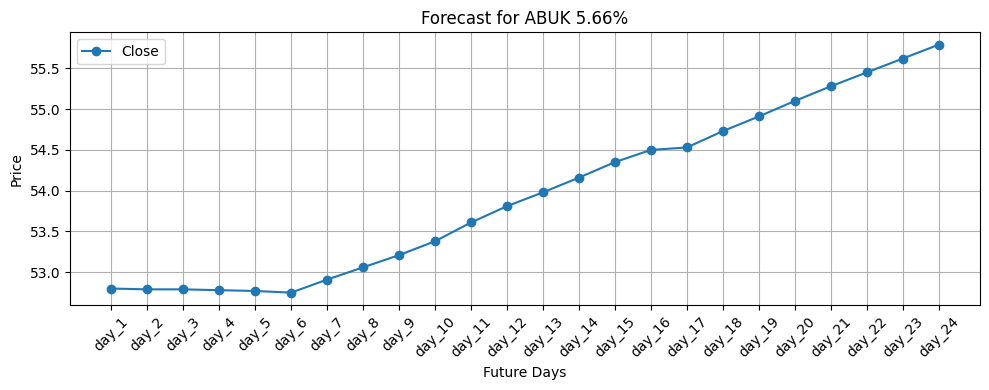

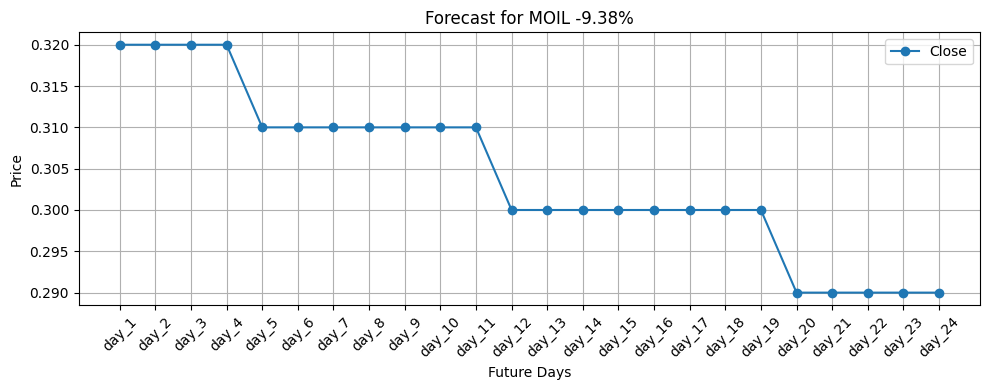

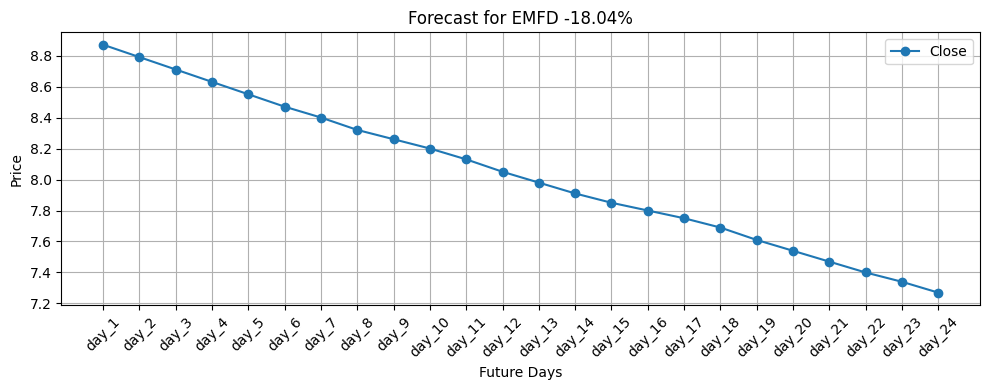

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

forcasting_df2 = forcasting_df.drop(columns=['expected_change_percent'])

# عدد الأيام
days = forcasting_df2.columns


for i in range(len(forcasting_df2.index)):
    close = forcasting_df2.iloc[i]
    company_name = forcasting_df2.index[i]

    plt.figure(figsize=(10, 4))
    plt.plot(days, close, label='Close', marker='o')

    plt.title(f'Forecast for {company_name} {forcasting_df["expected_change_percent"][company_name]}')
    plt.xlabel('Future Days')
    plt.xticks(rotation=45)
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
